In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, Input
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import BatchNormalization
from keras.regularizers import l2

#### 계속 재직할 것 같은 사람과 조만간 퇴사할 것 같은 사람 분류

##### ✅ train: 3,722 / test: 931

##### 💡사내 직원 데이터로부터 해당 직원의 퇴사 여부를 결정하는 Binary Classification task


In [ ]:
import os
os.chdir('/content/drive/MyDrive/final/assignment/')

In [ ]:
!pwd

/content/drive/MyDrive/final/assignment


In [ ]:
df = pd.read_csv('./dataset/train.csv')

In [ ]:
df.head(5)
# (순서 의미 x)범주형 변수: City, Gender, EverBenched -> 범주형 변수도 one-hot 처리 후 상관관계 확인해봐야 할 듯

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2012,New Delhi,3,38,Female,No,1,0
1,Bachelors,2018,Bangalore,3,26,Male,No,4,1
2,Bachelors,2016,Pune,3,27,Male,No,5,0
3,Bachelors,2016,Bangalore,3,36,Male,No,4,0
4,Bachelors,2017,Bangalore,3,27,Male,Yes,5,0


In [ ]:
# 결측치 확인, 없음
df.isnull().sum().sort_values(ascending=False)

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [ ]:
def cat2num(df):
    categorical_columns = ['Education', 'City','Gender', 'EverBenched'] # 다르지 않으니 그냥 함수 안에
    dummies = [pd.get_dummies(df[col], prefix=col) for col in categorical_columns]
    df = df.drop(categorical_columns, axis=1)

    for dummy in dummies:
        df = pd.concat([df, dummy], axis=1)

    return df

In [ ]:
# 범주형 변수 One-hot Encoding
df = cat2num(df)

In [ ]:
df.head(5)

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes
0,2012,3,38,1,0,1,0,0,0,1,0,1,0,1,0
1,2018,3,26,4,1,1,0,0,1,0,0,0,1,1,0
2,2016,3,27,5,0,1,0,0,0,0,1,0,1,1,0
3,2016,3,36,4,0,1,0,0,1,0,0,0,1,1,0
4,2017,3,27,5,0,1,0,0,1,0,0,0,1,0,1


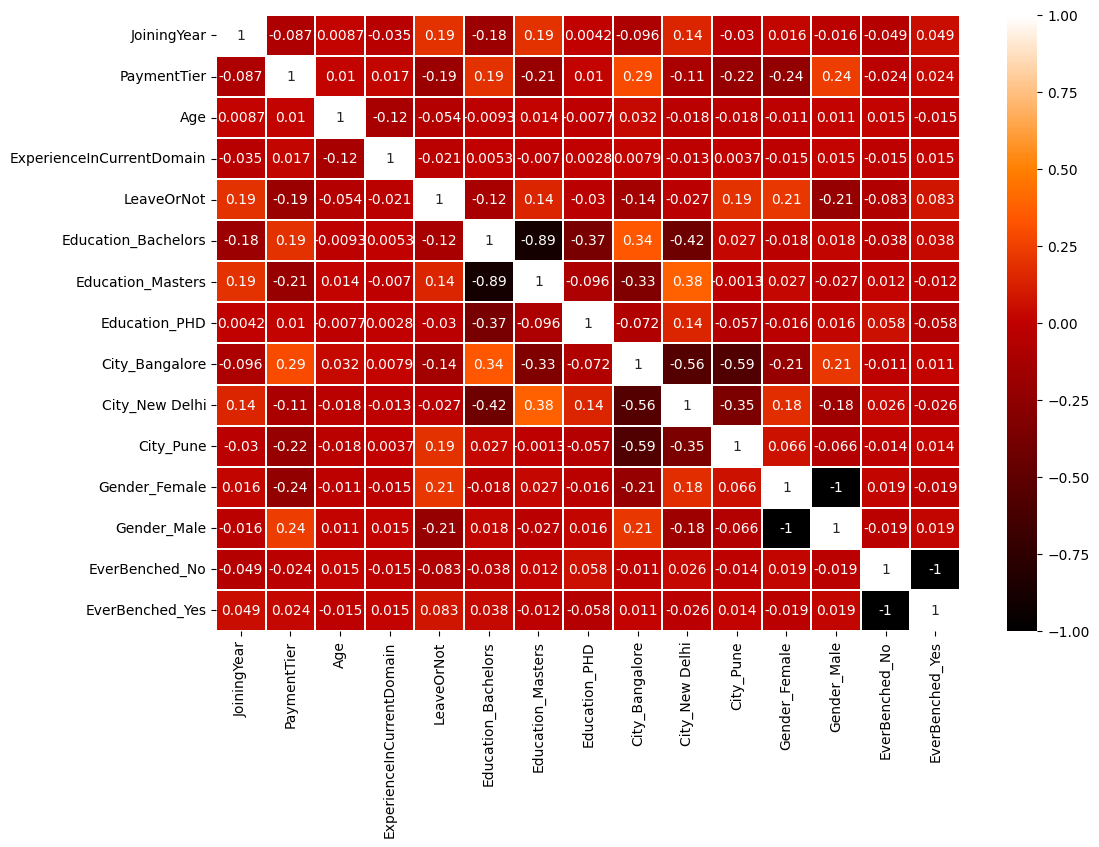

In [ ]:
# 상관관계 확인(with heatmap)
colormap = plt.cm.gist_heat

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap=colormap, linecolor='white', linewidth=0.1, annot=True)
plt.show() # 밝은 색 -> 양의 상관관계, 어두운 색 -> 관련 없음(0에 가까움)

In [ ]:
y = df['LeaveOrNot']
df = df.drop('LeaveOrNot', axis=1)
df = df.drop('Gender_Male', axis=1) # 상관계수가 제일 낮은 Gender_Male 삭제

### lightGBM

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2, shuffle=True)

In [ ]:
! pip install catboost

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import catboost as cb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=200, random_state=42)

In [ ]:
lgb_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    min_data_in_leaf=20,
    metric='binary_error',
    num_leaves=50,
    learning_rate=0.05,
    feature_fraction=0.9
)

In [ ]:
# CatBoost
cb_model = cb.CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=16,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
)

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
stacking_model = StackingClassifier(
    estimators=[('lgb', lgb_model), ('cb', cb_model), ('rf', rf_model), ('gb', gb_model)],  # Specify base classifiers
    final_estimator=LGBMClassifier(),  # Specify meta classifier
    stack_method='auto',
    passthrough=True,
    cv=5
)

In [ ]:
stacking_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 1025, number of negative: 1952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 2977, number of used features: 13
[LightGBM

StackingClassifier(cv=5,
                   estimators=[('lgb',
                                LGBMClassifier(feature_fraction=0.9,
                                               learning_rate=0.05,
                                               metric='binary_error',
                                               min_data_in_leaf=20,
                                               num_leaves=50,
                                               objective='binary')),
                               ('cb',
                                <catboost.core.CatBoostClassifier object at 0x78257df89330>),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(n_estimators=200,
                                                           random_state=42))],
                   final_estimator=LGBMClassifier(), passthrough=True)

In [ ]:
stacking_train_predictions = stacking_model.predict(X_train)
stacking_valid_predictions = stacking_model.predict(X_valid)

binary_train_predictions = (stacking_train_predictions >= 0.5).astype(int)
binary_valid_predictions = (stacking_valid_predictions >= 0.5).astype(int)

stacking_train_accuracy = accuracy_score(y_train, stacking_train_predictions)
stacking_valid_accuracy = accuracy_score(y_valid, stacking_valid_predictions)

print(f'Stacking Training Accuracy: {stacking_train_accuracy}')
print(f'Stacking Validation Accuracy: {stacking_valid_accuracy}')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Stacking Training Accuracy: 0.8629492777964394
Stacking Validation Accuracy: 0.8617449664429531


### Test

In [ ]:
test_df = pd.read_csv('./dataset/test.csv')

In [ ]:
# train 조건과 같이 전처리
test_df = cat2num(test_df)
test_df = test_df.drop('Gender_Male', axis=1)

In [ ]:
X_test = test_df
test_predictions = stacking_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [ ]:
print(len(test_predictions))

931


### submission.csv에 기록

In [ ]:
# submission.csv에 기록
sub_csv = pd.read_csv('submission3.csv')
print(sub_csv.columns)
sub_csv['LeaveOrNot'] = test_predictions

Index(['ID', 'LeaveOrNot'], dtype='object')


In [ ]:
sub_csv.to_csv('submission3.csv', index=False)

##### 1st: loss: 0.3677 - accuracy: 0.8466 - val_loss: 0.3231 - val_accuracy: 0.8758  / evaluate - loss: 0.3918 - accuracy: 0.8322

2nd: loss: 0.3980 - accuracy: 0.8529 - val_loss: 0.3932 - val_accuracy: 0.8557 / evaluate - loss: 0.4336 - accuracy: 0.8336

3th:
Average Cross-Validation Accuracy: 0.8509 ▶️ submission1.csv

4th(drop Gender_Male): Average Cross-Validation Accuracy: 0.8514 ▶️ submission2.csv